# ML - assignment_3

In [12]:
# importing libraries
import pandas as pd
import numpy as np
import shap
import math

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", palette="pastel")

import warnings
warnings.filterwarnings('ignore')

## EDA (Exploratory Data Analysis)

In [13]:
# reading the data into a DataFrame
df = pd.read_csv(r'train.csv')

In [14]:
# inspecitng the head of the dataframe
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [15]:
# inspecting info of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [16]:
# zooming in on missing values
df.isnull().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

In [17]:
# inspecting the df statistics
df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [18]:
# getting all var_x columns
features_to_plot = [col for col in df.columns if 'var' in col]
# defining 5 plots per row
plots_per_row = 5
# extracting the number of plots by the length of columns
number_of_plots = len(features_to_plot)
# calculating the amount of rows needed (rounded up)
number_of_rows = math.ceil(number_of_plots / plots_per_row)

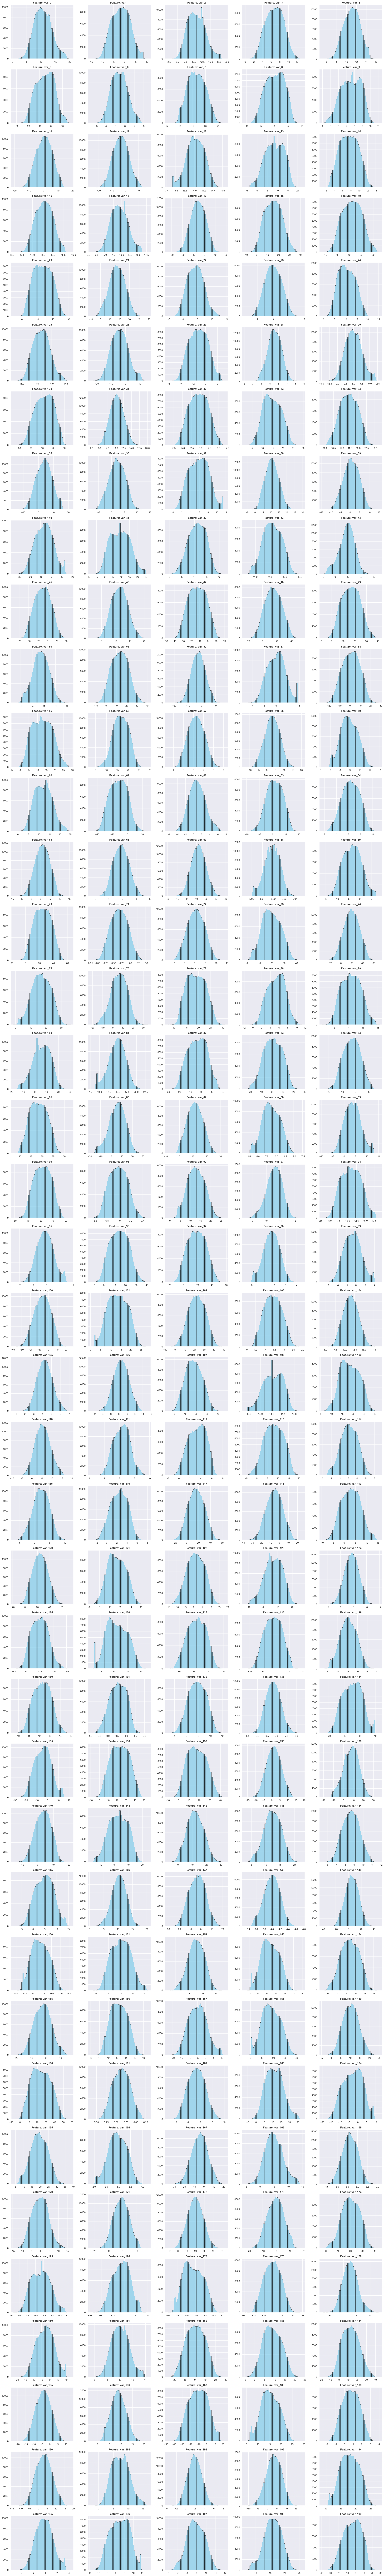

In [8]:
# defining the figure canvas
plt.figure(figsize=(24, number_of_rows * 4)) 
# creating a loop to go over all columns, each col is getting a subplot
for i, col in enumerate(features_to_plot):
    plt.subplot(number_of_rows, plots_per_row, i + 1)
    
    # Using bins=50 for performance on large datasets
    sns.histplot(df[col], bins=50, kde=False, color='skyblue', edgecolor='black', linewidth=0.5)
    
    plt.title(col, fontsize=10, fontweight='bold')
    plt.xlabel('') # Hiding x-label to save space
    plt.ylabel('') # Hiding y-label to clean up noise
    
    plt.title(f"Feature: {col}", fontsize=12, fontweight='bold', color='#333333')

plt.tight_layout()
plt.show()

In [20]:
#cheking the min and max for all of the features in the dataset
features = [col for col in df.columns if 'var' in col]
summary_df = df[features].agg(['min', 'max']).transpose()
summary_df['range'] = summary_df['max'] - summary_df['min']
summary_df = summary_df.sort_values(by='range', ascending=False)

print("--- Variables with the Largest Range ---")
print(summary_df.head(10))

print("\n--- Variables with the Smallest Range ---")
print(summary_df.tail(10))

--- Variables with the Largest Range ---
             min      max     range
var_45  -90.2525  62.0844  152.3369
var_74  -34.1015  70.2720  104.3735
var_117 -31.8369  64.8109   96.6478
var_120 -18.6962  74.0321   92.7283
var_149 -41.1683  48.4240   89.5923
var_90  -61.7180  27.2713   88.9893
var_70  -17.0275  64.4644   81.4919
var_97  -21.7400  58.2879   80.0279
var_48  -23.9022  54.2738   78.1760
var_61  -48.8027  27.1029   75.9056

--- Variables with the Smallest Range ---
             min      max   range
var_25   12.7200  14.6546  1.9346
var_43   10.6528  12.5779  1.9251
var_71   -0.2240   1.5719  1.7959
var_161   4.8526   6.3099  1.4573
var_148   3.3205   4.7528  1.4323
var_12   13.4346  14.6545  1.2199
var_103   0.9793   2.1887  1.2094
var_108  13.7290  14.7430  1.0140
var_91    6.5218   7.4895  0.9677
var_68    4.9938   5.0469  0.0531


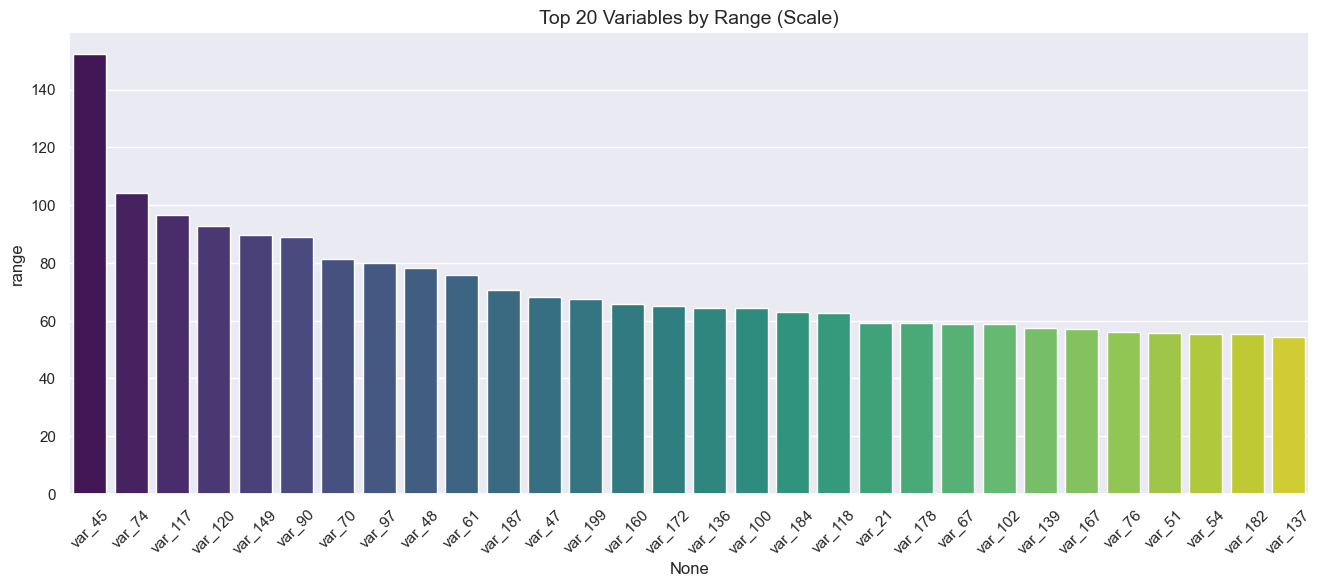

In [21]:
#visualizing top 30 features range descending 
plt.figure(figsize=(16, 6))
sns.barplot(x=summary_df.index[:30], y=summary_df['range'][:30], palette='viridis')
plt.title("Top 20 Variables by Range (Scale)", fontsize=14)
plt.xticks(rotation=45)
plt.show()

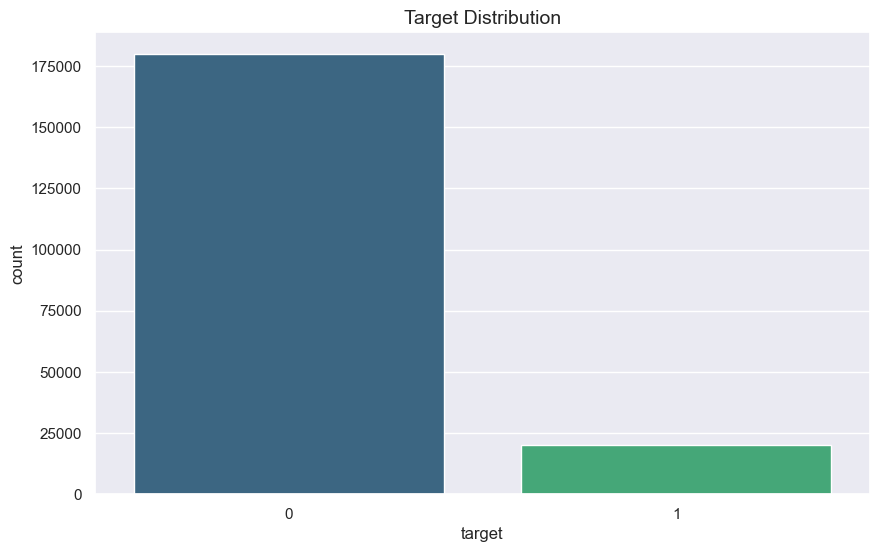

In [11]:
#visualizing the target distribution 
plt.figure(figsize=(10, 6))
sns.countplot(x=df['target'], palette='viridis')
plt.title("Target Distribution", fontsize=14)
plt.show()